# TIM - The Ineference Machine

## This is the first tutorial for TIM, the code-formally-known as PEYOte.
May PEYOte rest in peace

TIM is a fast, easy to use parameter estimation code for gravitational-wave astronomy.  This tutorial will take you through the basics steps of creating a model waveform, injecting that waveform into simulated noise, and then recovering that signal.

In [1]:
%pylab inline
# %matplotlib notebook
import numpy as np
import pylab as plt

%load_ext autoreload
%autoreload 2
import peyote
import corner

Populating the interactive namespace from numpy and matplotlib


## Define a source and simulate data

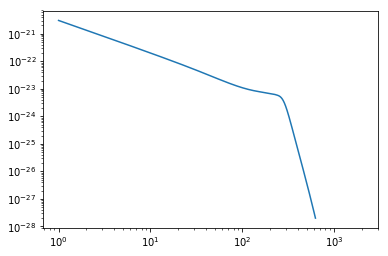

In [2]:
time_duration = 1.
sampling_frequency = 4096.

simulation_parameters = dict(
    mass_1 = 36.,
    mass_2 = 29.,
    spin_1 = [0, 0, 0], 
    spin_2 = [0, 0, 0],
    luminosity_distance = 410.,
    inclination_angle = 0., 
    waveform_phase = 0., 
    waveform_approximant = 'IMRPhenomPv2',
    reference_frequency = 50.,
    ra = 0,
    dec = 1,
    geocent_time = 0,
    psi=1
    )

source = peyote.source.BinaryBlackHole('BBH', sampling_frequency, time_duration)
hf_signal = source.frequency_domain_strain(simulation_parameters)

plt.loglog(source.frequency_array, np.abs(hf_signal['plus']))
plt.show()

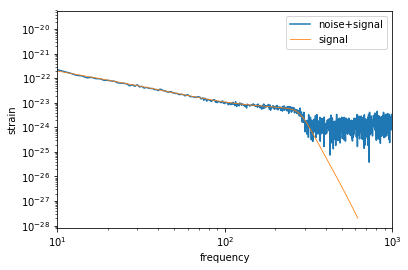

In [3]:
# Simulate the data in H1
IFO = peyote.detector.H1
hf_noise, frequencies = IFO.power_spectral_density.get_noise_realisation(
    sampling_frequency, time_duration)
IFO.set_data(frequency_domain_strain=hf_noise)
IFO.inject_signal(source, simulation_parameters)
IFO.set_spectral_densities(frequencies)
IFO.whiten_data()

# Plot the noise and signal
plt.loglog(frequencies, np.abs(hf_noise), lw=1.5, label='noise+signal')
plt.loglog(frequencies, np.abs(hf_signal['plus']), lw=0.8, label='signal')
plt.xlim(10, 1000)
plt.legend()
plt.xlabel(r'frequency')
plt.ylabel(r'strain')
plt.show()

## Search the data

In [5]:
%%time

likelihood = peyote.likelihood.likelihood([IFO], source)

prior = simulation_parameters.copy()
prior['mass_1'] = peyote.parameter.Parameter(
    'mass_1', prior=peyote.prior.Uniform(lower=35, upper=37))
prior['mass_2'] = peyote.parameter.Parameter(
    'mass_2', prior=peyote.prior.Uniform(lower=28, upper=30))

result = peyote.run_sampler(likelihood, prior, 'nestle', npoints=100)

Search parameters = ['mass_2', 'mass_1']
CPU times: user 1min 28s, sys: 67.7 ms, total: 1min 28s
Wall time: 29.5 s


/home/user1/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


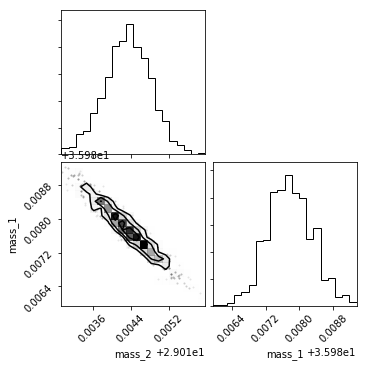

In [7]:
truths = [simulation_parameters[k] for k in result.parameter_keys]
fig = corner.corner(result.samples, labels=result.parameter_keys,
                    truths=truths)
fig.show()